Items to wrap up:
1. Make a lot of the computations into a package
2. Clean up to show descriptive only
3. Make sure demo works for images
4. Store the data in a set place
5. Load what's needed, when needed
6. Demo dry-run 

Do some initial cleansing and visualization to find things that would be interesting. Use this to determine which models I would want to make it initially capable of using

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import requests
from PIL import Image
from io import BytesIO
from math import ceil
from wordcloud import WordCloud
from difflib import SequenceMatcher
import spacy

In [2]:
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 50)

In [4]:
raw_data = pd.read_csv('../cleansing/data/appstore_games.csv')

In [4]:
raw_data.drop_duplicates(subset='ID', inplace = True)

In [5]:
dat = raw_data.copy()

Initial Visualizations

#### Ratings

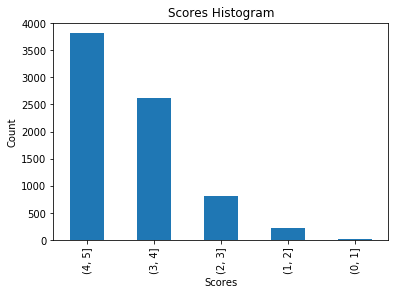

In [6]:
bins = [0,1,2,3,4,5]
pd.cut(dat['Average User Rating'], bins).value_counts().plot(kind = 'bar')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.title('Scores Histogram')
plt.show()

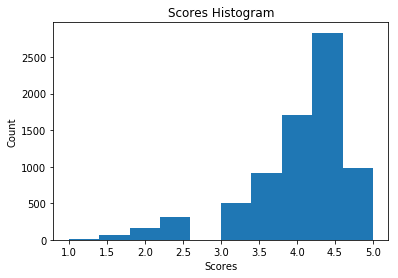

In [111]:
plt.hist(dat['Average User Rating'].dropna())
plt.xlabel('Scores')
plt.ylabel('Count')
plt.title('Scores Histogram')
plt.show()

Count of ratings

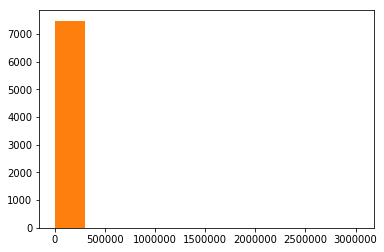

In [110]:
plt.hist(dat['User Rating Count'].dropna())
plt.show()

Some outliers making this strange, narrow the scope and look again

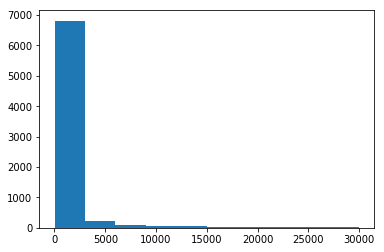

In [112]:
plt.hist(dat[dat['User Rating Count'] < 30000]['User Rating Count'].dropna())
plt.show()

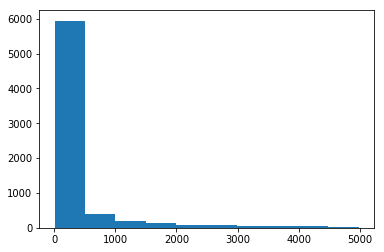

In [113]:
plt.hist(dat[dat['User Rating Count'] < 5000]['User Rating Count'].dropna())
plt.show()

Most between 0 and 500

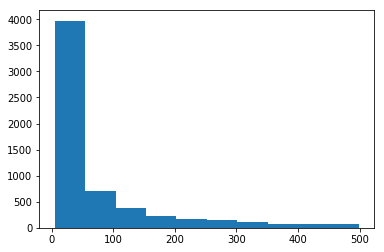

In [114]:
plt.hist(dat[dat['User Rating Count'] < 500]['User Rating Count'].dropna())
plt.show()

#### Cost

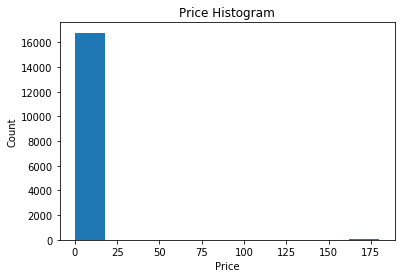

In [8]:
plt.hist(dat['Price'].dropna())
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price Histogram')
plt.show()

Take a closer look at the majority of the data

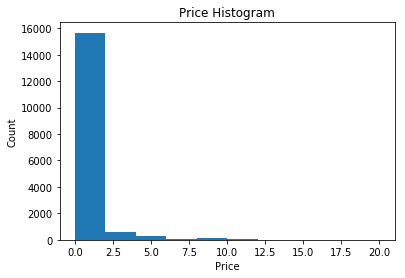

In [9]:
plt.hist(dat[dat['Price'] < 25]['Price'].dropna())
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price Histogram')
plt.show()

Heavilly skewed to include free games

Look at non-free and narrow the scope again

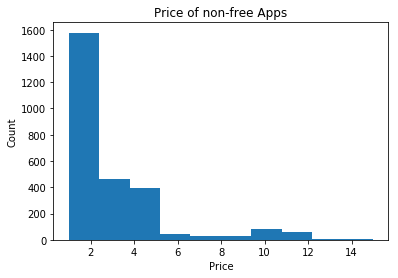

In [10]:
plt.hist(dat[(dat['Price'] < 15) & (dat['Price'] != 0)]['Price'].dropna())
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price of non-free Apps')
plt.show()

In [193]:
dat[(dat['Price'] == 0)].shape

(14084, 23)

In [188]:
dat.shape

(16847, 23)

In [194]:
14084 / 16847

0.8359945390870778

In [195]:
def visualize_raw_dat_ratings():
    dat = pd.read_csv('../data/appstore_games.csv')
    dat.drop_duplicates(subset='ID', inplace = True)
    
    # Ratings Plots
    print('Plots for Ratings Data')
    
    # Shown as binned ratings
    bins = [0,1,2,3,4,5]
    pd.cut(dat['Average User Rating'], bins).value_counts().plot(kind = 'bar')
    plt.xlabel('Scores')
    plt.ylabel('Count')
    plt.title('Scores Histogram')
    plt.show()
    
    #Show all ratings
    plt.hist(dat['Average User Rating'].dropna())
    plt.xlabel('Scores')
    plt.ylabel('Count')
    plt.title('Scores Histogram')
    plt.show()
    
    print('Number of Reviews')
    
    plt.hist(dat['User Rating Count'].dropna())
    plt.show()
    
    print('There is a long-tail to the data, so a subset will be shown as well')
    print('~80% of the data is pictured below')
    plt.hist(dat[dat['User Rating Count'] < 500].dropna(subset = ['User Rating Count'])['User Rating Count'])
    plt.show()

In [199]:
def visualize_raw_dat_cost():
    dat = pd.read_csv('../data/appstore_games.csv')
    dat.drop_duplicates(subset='ID', inplace = True)
    
    print('Cost of Games')
    
    plt.hist(dat['Price'].dropna())
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.title('Price Histogram')
    plt.show()
    
    print('Previous graph also has a long-tail. Will narrow the scope again')
    print('~99% of results in following graph')
    
    plt.hist(dat[(dat['Price'] < 15)]['Price'].dropna())
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.title('Price of Apps')
    plt.show()
    
    print('''84% of apps are free, skewing the results further. 
    Looking into only non-free apps for a clearer picture on what remains''')
    
    plt.hist(dat[(dat['Price'] < 15) & (dat['Price'] != 0)]['Price'].dropna())
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.title('Price of non-free Apps')
    plt.show()

Plots for Ratings Data


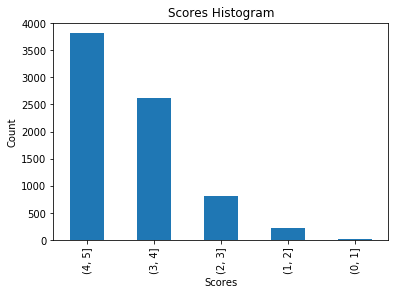

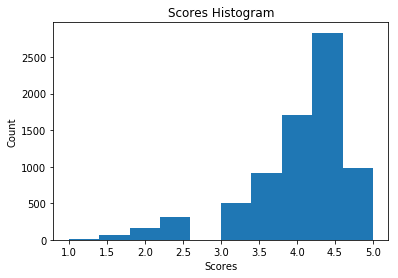

Number of Reviews


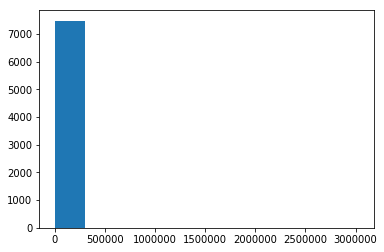

There is a long-tail to the data, so a subset will be shown as well
~80% of the data is pictured below


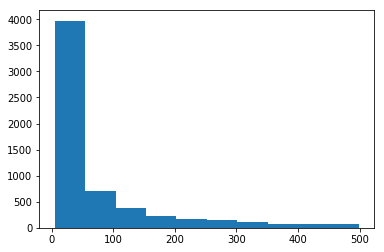

In [197]:
visualize_raw_dat_ratings()

Cost of Games


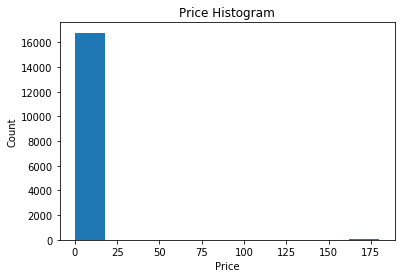

Previous graph also has a long-tail. Will narrow the scope again
~99% of results in following graph


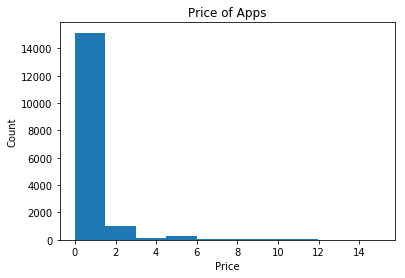

84% of apps are free, skewing the results further. 
    Looking into only non-free apps for a clearer picture on what remains


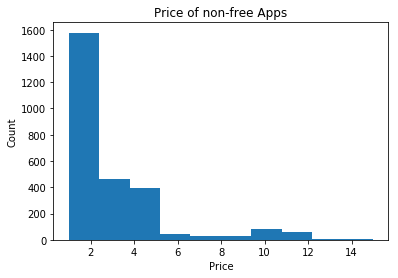

In [200]:
visualize_raw_dat_cost()

## Truly Free vs cost and see what we find

In app purchases being nan => 0

In [11]:
dat['In-app Purchases'].fillna('0', inplace = True)

In [12]:
dat['true_free'] = (dat.Price == 0) & (dat['In-app Purchases'] == '0')

In [203]:
dat[dat.true_free == True].shape

(7062, 23)

In [204]:
dat[dat.true_free != True].shape

(9785, 23)

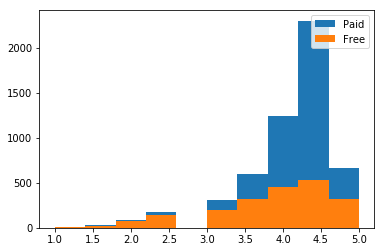

In [201]:
plt.hist(dat[dat.true_free == False]['Average User Rating'].dropna().values, label='Paid')
plt.hist(dat[dat.true_free == True]['Average User Rating'].dropna().values, label='Free')

plt.legend(loc='upper right')
plt.show()

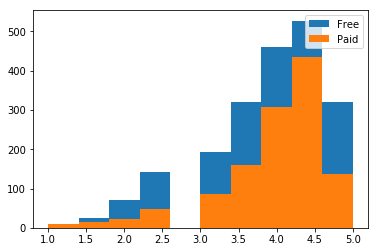

In [212]:
plt.hist(dat[dat.true_free == True]['Average User Rating'].dropna().values, label='Free')
plt.hist(dat[(dat.true_free == False) & (dat.Price != 0)]['Average User Rating'].dropna().values, label='Paid')

plt.legend(loc='upper right')
plt.show()

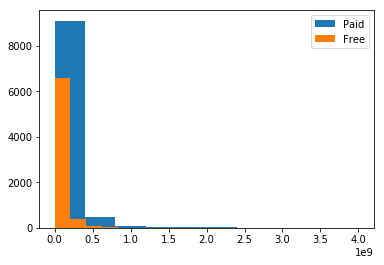

In [14]:
plt.hist(dat[dat.true_free == False]['Size'].dropna().values, label='Paid')
plt.hist(dat[dat.true_free == True]['Size'].dropna().values, label='Free')

plt.legend(loc='upper right')
plt.show()

In [348]:
def autolabel(rects, counts):
    """
    Attach a text label above each bar displaying its height
    """

    '''
    Got this from 
    https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh

    Altered it to but whatever text I wanted on the bar instead of the height
    '''
    for x, rect in zip(counts, rects1):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                'n = ' + str(x),
                ha='center', va='bottom')

def prep_visualize_cost():
    dat = pd.read_csv('../data/appstore_games.csv')
    dat.drop_duplicates(subset='ID', inplace = True)
    
    # Assume if null then there are no in-app purchases since all others have a value
    dat['In-app Purchases'].fillna('0', inplace = True)
    
    # An app is only actually free if you cant buy anything once in it
    dat['true_free'] = (dat.Price == 0) & (dat['In-app Purchases'] == '0')
    
    # Look at only if there is a base cost first and see if rating difference exists
    
    print('Investigate differences in ratings by free vs. paid App')
    plt.hist(dat[dat.true_free == True]['Average User Rating'].dropna().values, label='Free', color = 'green')
    plt.hist(dat[(dat.true_free == False) & (dat.Price != 0)]['Average User Rating'].dropna().values, label='Paid')

    plt.legend(loc='upper right')
    plt.show()
    
    print('Many Apps included pain content within them. These should not truly be considered "free"')
    
    plt.hist(dat[dat.true_free == False]['Average User Rating'].dropna().values, label='Paid')
    plt.hist(dat[dat.true_free == True]['Average User Rating'].dropna().values, label='Free', color = 'green')

    plt.legend(loc='upper right')
    plt.show()
    
    print('Which are truly best?')
    
    non_true_free_rating = dat[dat.true_free == False]['Average User Rating'].dropna().mean()
    in_app_purchases = dat[(dat.true_free == False) & (dat.Price == 0)]['Average User Rating'].dropna().mean()
    true_free_rating = dat[dat.true_free == True]['Average User Rating'].dropna().mean()
    zero_cost_rating = dat[dat.Price == 0]['Average User Rating'].dropna().mean()
    paid_rating = dat[dat.Price != 0]['Average User Rating'].dropna().mean()

    non_true_free_rating_cnt = dat[dat.true_free == False]['Average User Rating'].dropna().shape[0]
    in_app_purchases_cnt = dat[(dat.true_free == False) & (dat.Price == 0)]['Average User Rating'].dropna().shape[0]
    true_free_rating_cnt = dat[dat.true_free == True]['Average User Rating'].dropna().shape[0]
    zero_cost_rating_cnt = dat[dat.Price == 0]['Average User Rating'].dropna().shape[0]
    paid_rating_cnt = dat[dat.Price != 0]['Average User Rating'].dropna().shape[0]

    plt.bar(['Zero Cost','Paid App'],
            [zero_cost_rating,paid_rating])
    plt.ylim((3.8,4.18))
    plt.xticks(rotation = 'vertical')
    plt.show()
    
    plt.bar(['Truly Free','Any Cost'],
            [true_free_rating,non_true_free_rating])
    plt.ylim((3.8,4.18))
    plt.xticks(rotation = 'vertical')
    plt.show()
    
    plt.bar(['Zero Cost','Truly Free','Paid App','Any Cost','In app-purchases'],
            [zero_cost_rating,true_free_rating,paid_rating,non_true_free_rating, in_app_purchases])
    plt.ylim((3.8,4.18))
    plt.xticks(rotation = 'vertical')
    plt.show()
    
    N = 5

    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, [zero_cost_rating,true_free_rating,paid_rating,non_true_free_rating, in_app_purchases], 
                    width, color='r')


    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_title('Scores by group and gender')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(['Zero Cost','Truly Free','Paid App','Any Cost','In app-purchases'])

    plt.ylim((3.85,4.18))

    counts = [zero_cost_rating_cnt,true_free_rating_cnt,paid_rating_cnt,non_true_free_rating_cnt, in_app_purchases_cnt]


    autolabel(rects1, counts)

    plt.show()

Investigate differences in ratings by free vs. paid App


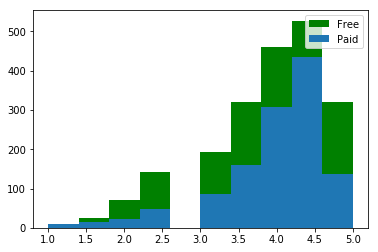

Many Apps included pain content within them. These should not truly be considered "free"


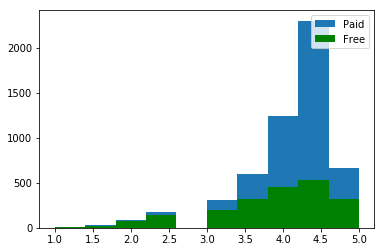

Which are truly best?


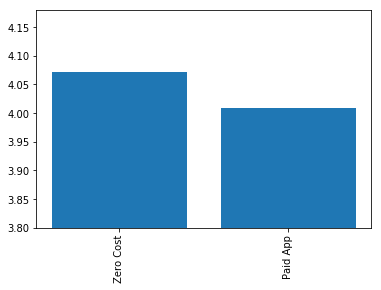

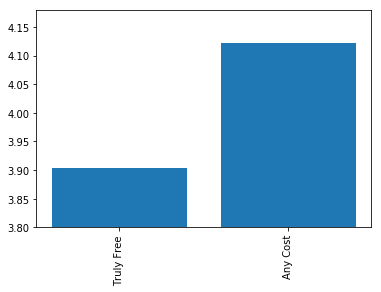

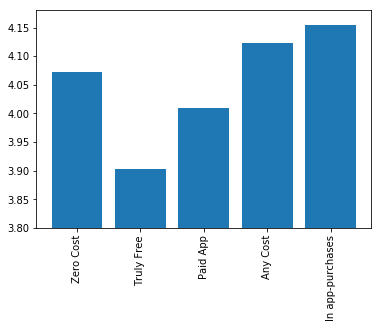

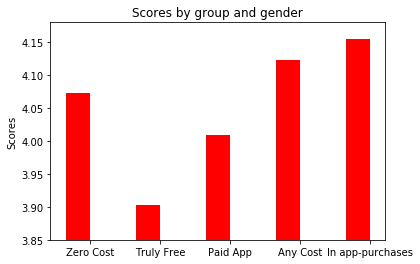

In [349]:
prep_visualize_cost()

Overwhelmingly games so look at the others only

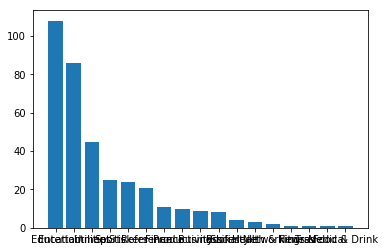

In [11]:
plt.bar(dat[dat.true_free == False]['Primary Genre'].value_counts().index[1:], 
        dat[dat.true_free == False]['Primary Genre'].value_counts().values[1:])
plt.show()

Time since last release at time data was pulled -> indicator of how active it is

Data stored as dd-mm-yyyy

In [144]:
dat['curr_release_date'] = pd.to_datetime(dat['Current Version Release Date'], format="%d/%m/%Y")

In [145]:
dat['time_since_update'] = (np.datetime64('2019-08-03') - dat['curr_release_date']).astype('timedelta64[D]')

Some are now negative since apparently they were released after the crawl? Going back to just using time since today's date

In [350]:
dat['time_since_update'] = (np.datetime64('today') - dat['curr_release_date']).astype('timedelta64[D]')

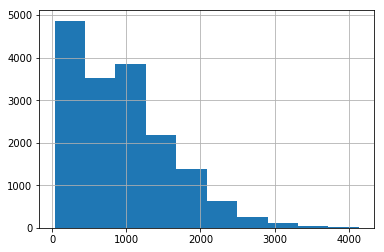

In [351]:
# Look at how many days since updates for apps
dat.time_since_update.hist()
plt.show()

In [356]:
dat['time_since_update_bin'] = pd.cut(dat.time_since_update, bins=10, labels=[i for i in range(10)])

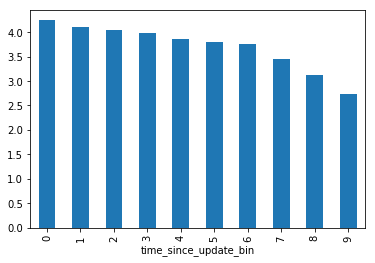

In [358]:
dat.groupby('time_since_update_bin')['Average User Rating'].mean().plot(kind = 'bar')
plt.show()

In [367]:
def time_since_update_stats(num_bins = 10):
    '''
    Previous steps needed to make this work:
    
    dat['curr_release_date'] = pd.to_datetime(dat['Current Version Release Date'], format="%d/%m/%Y")
    dat['time_since_update'] = (np.datetime64('today') - dat['curr_release_date']).astype('timedelta64[D]')
    
    '''
    
    print('Loading previously parsed file from ../data/parsed_data.parquet')
    
    dat = pd.read_parquet('../data/parsed_data.parquet')
    
    dat.time_since_update.hist()
    plt.show()
    
    print('Segmenting data with ' + str(num_bins) + ' bins')
    dat['time_since_update_bin'] = pd.cut(dat.time_since_update, bins=num_bins, labels=[i for i in range(num_bins)])
    
    dat.groupby('time_since_update_bin')['Average User Rating'].mean().plot(kind = 'bar')
    plt.show()

Loading previously parsed file from ../data/parsed_data.parquet


/anaconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/anaconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/anaconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


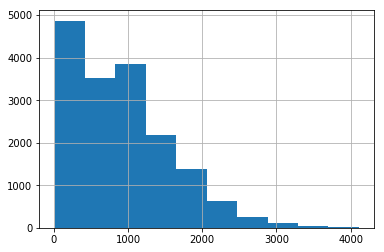

Segmenting data with 20 bins


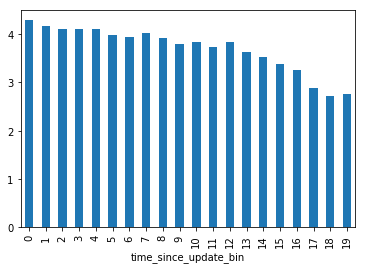

In [368]:
time_since_update_stats(20)

See if URL or images are still active now

In [17]:
images = []
for i in dat['Icon URL'].values:
    try:
        response = requests.get(i)
        images.append(response.content)
    except Exception as e:
        images.append(None)

KeyboardInterrupt: 

In [18]:
len(images)

16733

In [20]:
images_2 = []
for i in dat['Icon URL'].values[len(images):]:
    try:
        response = requests.get(i)
        images_2.append(response.content)
    except Exception as e:
        images_2.append(None)

In [21]:
images_3 = images + images_2

In [22]:
len(images_3)

16847

In [24]:
dat['image_bytes'] = images_3

In [25]:
dat.to_parquet('../data/parsed_data.parquet')

/anaconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


In [131]:
def desc_cleanser(txt):
    # New line issues
    txt = re.sub(r'\\n', r' ', txt)
    # Unicode cleanse
    txt = re.sub(r'\\u[\d]{4}', r'', txt)
    # Remaining unicode cleanse
    txt = re.sub(r'\\{1,2}\S+', r' ', txt)
    # Remove more than a single space
    txt = re.sub(r'\s+', r' ', txt)
    
    return txt

In [134]:
dat['parsed_desc'] = dat.Description.apply(desc_cleanser)

In [146]:
dat.sort_values('time_since_update')

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,true_free,curr_release_date,time_since_update,image_bytes,parsed_desc
16980,https://apps.apple.com/us/app/block-soldier-sniper/id1474206079,1474206079,Block Soldier Sniper,Block Sniper,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/05/85/af/0585af51-2fe3-9fa2-8e83-d9b6b20d0...,NaN,NaN,NaN,"2.99, 9.99",This is block wars the game. This sniper games is very funny\n\nFeatures of Game:\n- Easy and fu...,VU HUU VIET,17+,EN,170358784.0,Games,"Games, Strategy, Casual, Entertainment",26/10/2019,26/10/2019,False,2019-10-26,-84.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00hExif\x00\x00MM\x00*...,This is block wars the game. This sniper games is very funny Features of Game: - Easy and fun to...
16951,https://apps.apple.com/us/app/war-shooting-battle-survival/id1473098634,1473098634,War Shooting Battle Survival,Shooting Battle Survival,https://is5-ssl.mzstatic.com/image/thumb/Purple123/v4/f2/50/7f/f2507f68-5bdc-d187-df27-958ad4fcd...,NaN,NaN,NaN,0,Play as a last world war hero to recapture army base in War Shooting Battle Survival. In this fi...,VONG KIM PHUONG,17+,EN,261016576.0,Games,"Games, Entertainment, Casual, Strategy",14/10/2019,14/10/2019,False,2019-10-14,-72.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00hExif\x00\x00MM\x00*...,Play as a last world war hero to recapture army base in War Shooting Battle Survival. In this fi...
16942,https://apps.apple.com/us/app/flying-carpet-shooting/id1472974346,1472974346,Flying Carpet Shooting,Carpet Shooting,https://is2-ssl.mzstatic.com/image/thumb/Purple113/v4/dc/37/7b/dc377b51-a369-ed84-724a-7bacdc303...,NaN,NaN,NaN,0,Fly through the skies with your magic carpet and shoot enermy\n\nGame Features:\n-Beautiful grap...,NGUYEN VAN QUANG,17+,EN,101702656.0,Games,"Games, Strategy, Entertainment, Music",13/10/2019,13/10/2019,False,2019-10-13,-71.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00hExif\x00\x00MM\x00*...,Fly through the skies with your magic carpet and shoot enermy Game Features: -Beautiful graphics...
16902,https://apps.apple.com/us/app/island-jurassic-survival/id1471952843,1471952843,Island Jurassic Survival,Dino Shooting,https://is1-ssl.mzstatic.com/image/thumb/Purple113/v4/be/f9/27/bef92797-e0b4-3ebb-0efe-d6ebb903a...,NaN,NaN,NaN,0,Island Jurassic Survival is a real thrill and fun game of enjoyment if you are a real hunter the...,NGUYEN THANG LONG,17+,EN,306213888.0,Games,"Games, Entertainment, Strategy, Action",9/10/2019,9/10/2019,False,2019-10-09,-67.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00hExif\x00\x00MM\x00*...,Island Jurassic Survival is a real thrill and fun game of enjoyment if you are a real hunter the...
16879,https://apps.apple.com/us/app/terrorist-shooter-city-missio/id1471495472,1471495472,Terrorist Shooter: City Missio,City Shooting Mission,https://is1-ssl.mzstatic.com/image/thumb/Purple113/v4/41/b7/35/41b73511-3548-a381-bc00-639b4a573...,NaN,NaN,NaN,0,"As a swat force agent and get ready to take down killers, terrorist and international criminals ...",VONG KIM PHUONG,17+,EN,222621696.0,Games,"Games, Strategy, Entertainment, Action",3/10/2019,3/10/2019,False,2019-10-03,-61.0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00H\x00H\x00\x00\xff\xe1\x00hExif\x00\x00MM\x00*...,"As a swat force agent and get ready to take down killers, terrorist and international criminals ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,https://apps.apple.com/us/app/lumen-lite/id288096268,288096268,Lumen Lite,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purple71/v4/b9/ab/5a/b9ab5a52-aea9-fc5c-02f6-2e892192d3...,3.5,5072.0,0.0,0,"""The objective of Lumen is to light up all the checkpoints in

In [149]:
dat.to_parquet('../data/parsed_data.parquet')

/anaconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:114: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  result = infer_dtype(pandas_collection)


In [16]:
dat = pd.read_parquet('../data/parsed_data.parquet')

/anaconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:707: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/anaconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:734: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/anaconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


## Will drop nulls across the board for image computation as they are very time-intensive

In [168]:
first = Image.open(BytesIO(images_3[0]))
second = Image.open(BytesIO(images_3[1]))

In [17]:
def dif_percentage(first,second):
    '''
    Pixel-wise differences between images
    '''
    i1 = first
    i2 = second
    assert i1.mode == i2.mode, "Different kinds of images."
    assert i1.size == i2.size, "Different sizes."

    pairs = zip(i1.getdata(), i2.getdata())
    
    #Manhatten distance for images
    
    if len(i1.getbands()) == 1:
        # for gray-scale jpegs
        dif = sum(abs(p1-p2) for p1,p2 in pairs)
    else:
        dif = sum(abs(c1-c2) for p1,p2 in pairs for c1,c2 in zip(p1,p2))

    ncomponents = i1.size[0] * i1.size[1] * 3
    return (dif / 255.0 * 100) / ncomponents

In [18]:
def dif_percentage_lst(first,lst):
    '''
    Pixel-wise differences between images
    Narrow the scope for images by resizing to be smaller for faster computations
    '''
    
    i1 = Image.open(BytesIO(first)).resize((50,50))
    hold = []
    for idx,i2 in enumerate(lst):
        i2 = Image.open(BytesIO(i2)).resize((50,50))
        if i1.mode != i2.mode:
            hold.append(100)
            continue
        assert i1.size == i2.size, "Different sizes."
        
        pairs = zip(i1.getdata(), i2.getdata())

        #Manhatten distance for images

        if len(i1.getbands()) == 1:
            # for gray-scale jpegs
            dif = sum(abs(p1-p2) for p1,p2 in pairs)
        else:
            dif = sum(abs(c1-c2) for p1,p2 in pairs for c1,c2 in zip(p1,p2))

        ncomponents = i1.size[0] * i1.size[1] * 3
                
        hold.append((dif / 255.0 * 100) / ncomponents)
    return hold


In [21]:
first = Image.open(BytesIO(dat.image_bytes[1]))
second = Image.open(BytesIO(dat.image_bytes[2]))
rands = Image.open(BytesIO(dat.image_bytes[50]))

In [22]:
dif_percentage(first, second)

18.08202506669986

Test for similarities of a single image

In [39]:
res = dif_percentage_lst(dat.dropna().image_bytes.values[0], dat.dropna().image_bytes.values)

In [41]:
def gather_names(df,lst,col):
    lst_return = []
    for i in lst:
        lst_return.append(df.iloc[i][col])
    return lst_return

In [42]:
gather_names(dat.dropna(),list(pd.Series(res).sort_values().index),'Name')

['Sudoku - Classic number puzzle',
 'Speedy Square!',
 'Kakuro Game',
 '2048+#',
 'Black Blue',
 'CityScape Sim',
 'NRTM',
 'Biocell',
 'Swim Out',
 'TicTacToe - Multiplayer Game',
 'Steampunk Puzzle Physics Game',
 'Slam Sky',
 'Conference Room Escape',
 'Kubos.',
 'Opp Ball',
 'Universal Papertoilet Clicker',
 'Net Deck',
 'Sudoku \\u229e',
 'FLASHFLUSH',
 'Guess Her Age',
 'Foodie Finds',
 'Tetra Cats',
 'Achi - Strategy game',
 'Sudoku+ Classic Puzzle',
 'Wall Ball - Bounce',
 'South Park: Phone Destroyer\\u2122',
 'Fortune City - Expense Tracker',
 'Pixel Plex',
 'Infection Go',
 'Domino! - Multiplayer Dominoes',
 'Idiot Test - Brain Teasers and Mind Games',
 'Magic Life Counter',
 '[Minesweeper]',
 'Sudoku - soduku puzzles',
 'Dual Match 3',
 'Sixteen The Puzzle',
 'SEA BATTLE ONLINE 2',
 'Laws of Civilization LITE',
 'Mahjong Catalog',
 'Idle Water Slide',
 'Card Creator for MtG',
 'Idle Donut Tycoon',
 'Laws of Civilization',
 'NightZero:Mistiltein',
 '"Crap! I\'m Broke: Out of

In [228]:
from matplotlib.pyplot import imshow

In [195]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [243]:
def visualize_image_sim():
    app = input('Please Specify an App')
    print('---' * 8)
    
    ratio = dat.Name.apply(lambda x: similar(app,x))
    top_3 = list(ratio.sort_values(ascending=False).index[0:3])
    top_3_names = dat.iloc[top_3].Name.values
    
    
    app_refine = input('The most similar items in this set are ' + 
                      ', '.join(top_3_names) +' please specify which you are interested in')
    
    print('---' * 8)
    print('Looking for ' + app_refine)
    print('---' * 8)
    
    while (app_refine not in top_3_names) and (app_refine != 'end'):
        app_refine = input('Exact match not found, please specify the exact app' + 
                      ', '.join(top_3_names))
        
    if app_refine == 'end':
        print('ending process')
        return
    
    
    print('Icon for chosen App will be Displayed in pop-up')
    
    curr_image = Image.open(BytesIO(dat[dat.Name == app_refine].image_bytes.values[0]))
    
    curr_image.show()
    
    print('---' * 8)
    print('Gathering Similar Images')
    print('---' * 8)
    
    res = dif_percentage_lst(dat[dat.Name == app_refine].image_bytes.values[0], dat.dropna().image_bytes.values)
    
    
    best_images = gather_names(dat.dropna(),list(pd.Series(res).sort_values().index),'Name')[1:4]
    
    print('Top image similarities are ' + ', '.join(best_images))
    print('---' * 8)
    
    view = input('Would you like to view the images? Y/N')
    print('---' * 8)
    
    if view == 'Y':
        for i in best_images:
            similar_image = Image.open(BytesIO(dat[dat.Name == i].image_bytes.values[0]))
            similar_image.show()
    
    print('Images displayed')
    
    return ratio

In [247]:
rat = visualize_image_sim()

Please Specify an AppSudoku
------------------------
The most similar items in this set are Sudoku, Clash of Legends: Heroes, Sea Jurassic Craft please specify which you are interested inSudoku
------------------------
Looking for Sudoku
------------------------
Icon for chosen App will be Displayed in pop-up
------------------------
Gathering Similar Images
------------------------
Top image similarities are Wooden Block Puzzle - Extreme, Bricks of Rome, Marble Solitaire : Peg Game
------------------------
Would you like to view the images? Y/NY
------------------------
Images displayed


# P2 - Similarity by current fields

In [23]:
text_sim_set = dat.copy()

### Prep data for algo

In [123]:
from sklearn.cluster import KMeans

In [56]:
text_sim_set.columns

Index(['URL', 'ID', 'Name', 'Subtitle', 'Icon URL', 'Average User Rating',
       'User Rating Count', 'Price', 'In-app Purchases', 'Description',
       'Developer', 'Age Rating', 'Languages', 'Size', 'Primary Genre',
       'Genres', 'Original Release Date', 'Current Version Release Date',
       'true_free', 'curr_release_date', 'time_since_update', 'image_bytes',
       'parsed_desc'],
      dtype='object')

In [59]:
text_sim_set[['Name', 'Subtitle', 'Average User Rating',
       'User Rating Count', 'Price', 'In-app Purchases',
       'Age Rating', 'Languages', 'Primary Genre',
       'Genres',
       'true_free', 'time_since_update',
       'parsed_desc']].head()

,Name,Subtitle,Average User Rating,User Rating Count,Price,In-app Purchases,Age Rating,Languages,Primary Genre,Genres,true_free,time_since_update,parsed_desc
0,Sudoku,None,4.0,3553.0,2.99,0,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT, RU, ZH, ES, SV, ZH",Games,"Games, Strategy, Puzzle",False,887.0,"Join over 21,000,000 of our fans and download one of our Sudoku games today! Makers of the Best ..."
1,Reversi,None,3.5,284.0,1.99,0,4+,EN,Games,"Games, Strategy, Board",False,535.0,"The classic game of Reversi, also known as Othello, is a much-loved strategy board game. It is o..."
2,Morocco,None,3.0,8376.0,0.00,0,4+,EN,Games,"Games, Board, Strategy",True,789.0,Play the classic strategy game Othello (also known as Reversi) on your iPhone or iPod Touch. The...
3,Sudoku (Free),None,3.5,190394.0,0.00,0,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT, RU, ZH, ES, SV, ZH",Games,"Games, Strategy, Puzzle",True,887.0,"Top 100 free app for over a year. Rated ""Best Sudoku Game of the Year"" by Apple. Rated #9 Game o..."
4,Senet Deluxe,None,3.5,28.0,2.99,0,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU, ZH, ES, SV",Games,"Games, Strategy, Board, Education",False,469.0,"""Senet Deluxe - The Ancient Game of Life and Afterlife Senet is an ancient Egyptian race game an..."


In [24]:
# From string to list
text_sim_set.Languages = text_sim_set.Languages.apply(lambda x: x.split(', ') if x is not None else None)
text_sim_set.Genres = text_sim_set.Genres.apply(lambda x: x.split(', ') if x is not None else None)

In [119]:
feats = pd.concat([text_sim_set[['Average User Rating',
       'User Rating Count', 'Price','true_free','time_since_update']],
                  pd.get_dummies(text_sim_set.Languages.apply(pd.Series).stack()).sum(level=0),
                 pd.get_dummies(text_sim_set.Genres.apply(pd.Series).stack()).sum(level=0)],
                  axis = 1)



Look into nulls which would interfere with modeling

In [120]:
(feats.isna().mean().round(4) * 100).sort_values()

Word                    0.00
Lifestyle               0.00
Kids & Family           0.00
Health & Fitness        0.00
Gaming                  0.00
                       ...  
LA                      0.36
LO                      0.36
KM                      0.36
User Rating Count      55.55
Average User Rating    55.55
Length: 167, dtype: float64

Only a few columns with significant nulls, User Ratings Count and Average User Rating. It would make sense to repalce these with 0 since that is actually what null would refer to.

Additionally, all other features are sparse and can be replaced with 0 as well.

In [121]:
feats.fillna(value=0, inplace=True)

Find optimal number of clusters

In [130]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=25, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(feats)
    distortions.append(km.inertia_)


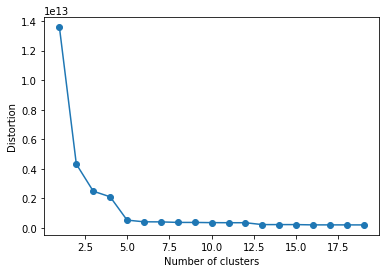

In [131]:
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Looks like ~5 clusters is ideal for this 

In [136]:
km = KMeans(
    n_clusters=5, init='random',
    n_init=25, max_iter=300, 
    tol=1e-04, random_state=6
)
y_km = km.fit_predict(feats)

Add back into main df

In [137]:
text_sim_set['cluster'] = y_km

Look into how well this did through more visualizations

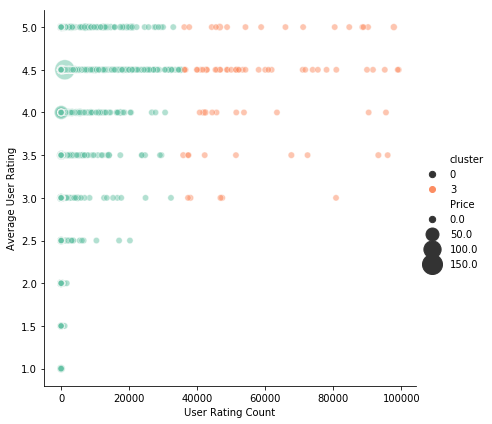

In [138]:
sns.relplot(x="User Rating Count", y="Average User Rating", hue="cluster", size="Price",
            sizes=(40, 400), alpha=.5,
            palette = sns.color_palette("Set2", n_colors = 2),
            height=6, data=text_sim_set[text_sim_set['User Rating Count'] < 100000])
plt.show()

In [139]:
text_sim_set.cluster.value_counts()

0    16729
3       93
2       22
4        2
1        1
Name: cluster, dtype: int64

### Unfortunately, most put into the same cluster which is not particularly useful. Can see clear segmentation based off of the count of user ratings which accounts for 99% of the data with the remaining 1% being apps with far more ratings than average

Will look at removing the feature causing this segmentation and redo the process

In [140]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(feats[list(feats.columns)[:1] + list(feats.columns)[2:]])
    distortions.append(km.inertia_)


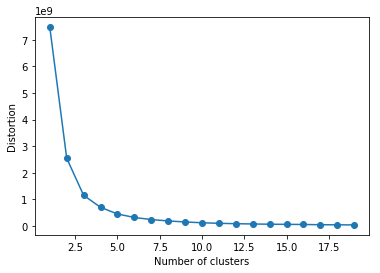

In [141]:
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

5 still seems fine

In [142]:
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km_2 = km.fit_predict(feats)

In [143]:
text_sim_set['cluster_2'] = y_km_2

In [144]:
text_sim_set.cluster_2.value_counts()

1    16729
3       93
0       22
2        2
4        1
Name: cluster_2, dtype: int64

Exactly the same issue here as well

Try different clustering methods

In [145]:
from sklearn.cluster import AgglomerativeClustering

In [146]:
clustering = AgglomerativeClustering(n_clusters=5).fit(feats)

In [148]:
hier_cluster = clustering.fit_predict(feats)

In [149]:
text_sim_set['hier_cluster'] = hier_cluster

In [150]:
text_sim_set.hier_cluster.value_counts()

1    16672
2      150
0       23
4        1
3        1
Name: hier_cluster, dtype: int64

## Leverage a word cloud to show differences between best games and the rest

In [15]:
nlp = spacy.load("en_core_web_sm")

In [80]:
text_sim_set['spacy_text'] = text_sim_set.parsed_desc.apply(lambda x: [i for i in nlp(x) if (i.is_stop == False 
                                                                                                and i.is_alpha == True)])

In [81]:
text_sim_set['desc_parsed_text'] = text_sim_set.spacy_text.apply(lambda x: [i.lemma_.lower() for i in x])

In [82]:
text_sim_set['desc_parsed_pos'] = text_sim_set.spacy_text.apply(lambda x: [i.pos_ for i in x])

In [90]:
text_sim_set['desc_parsed_ents'] = text_sim_set.spacy_text.apply(lambda x: 
                                                                 [i.ent_type_ for i in x if i.ent_type_ != ''])

In [92]:
text_sim_set.to_csv('text_sim_set.csv')

In [95]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=6
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [105]:
high_scores = ' '.join(text_sim_set[text_sim_set['Average User Rating'] >= 4].desc_parsed_text.apply(lambda x: ' '.join(x)))
lower_scores = ' '.join(text_sim_set[text_sim_set['Average User Rating'] < 4].desc_parsed_text.apply(lambda x: ' '.join(x)))

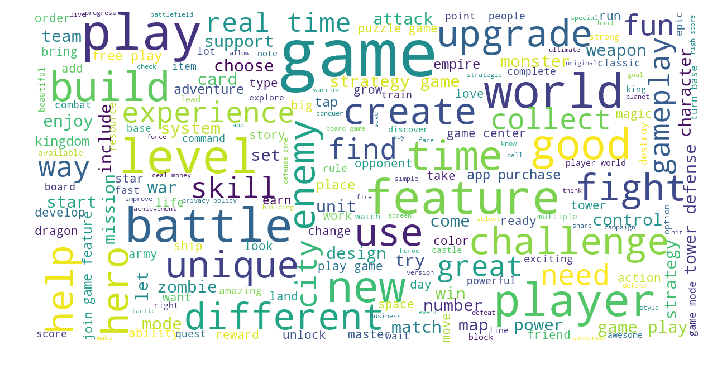

In [106]:
show_wordcloud(high_scores)

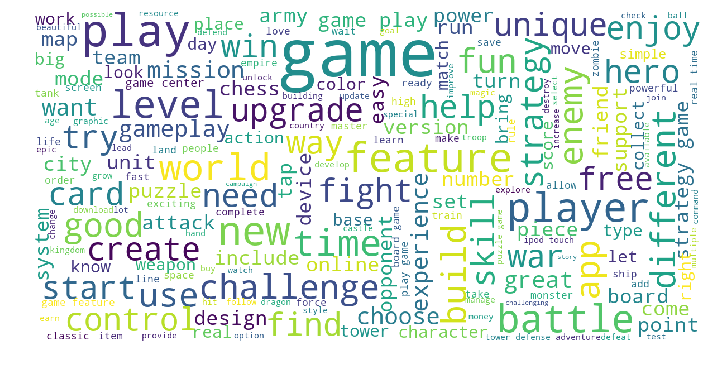

In [107]:
show_wordcloud(lower_scores)

In [116]:
most_reviews = ' '.join(text_sim_set[text_sim_set['User Rating Count'] >= 250].desc_parsed_text.apply(lambda x: ' '.join(x)))
less_reviews = ' '.join(text_sim_set[text_sim_set['Average User Rating'] < 250].desc_parsed_text.apply(lambda x: ' '.join(x)))

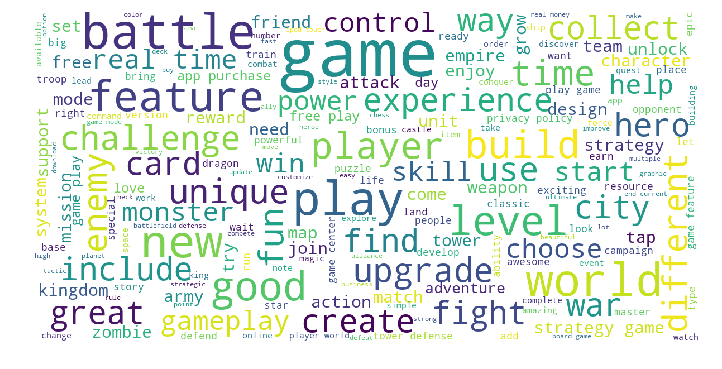

In [117]:
show_wordcloud(most_reviews)

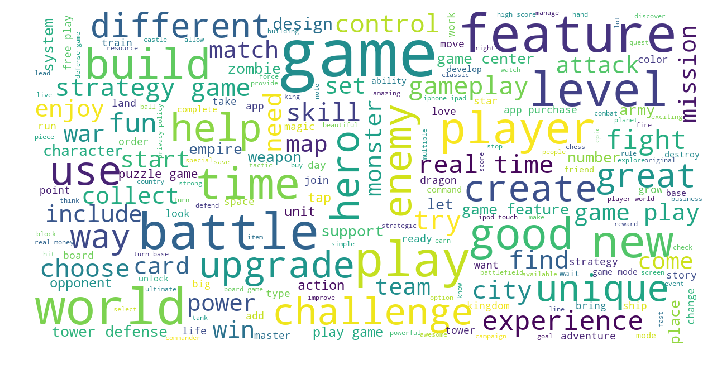

In [118]:
show_wordcloud(less_reviews)